# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [336]:
!pip install ydata_profiling phik

In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from ydata_profiling import ProfileReport
import phik

random.seed(42)
np.random.seed(42)

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

Сиды фиксируем для воспроизводимости результатов. Чтобы не менялись результаты от запуска к запуску, что специфично для машинного обучения.

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [338]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [X] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [X] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [X] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [X] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [339]:
missing_train = df_train.isnull().sum()
missing_train = missing_train[missing_train > 0]

print("Колонки с пропусками в train:")
missing_train

Колонки с пропусками в train:


mileage      202
engine       202
max_power    196
torque       203
seats        202
dtype: int64

In [340]:
missing_test = df_test.isnull().sum()
missing_test = missing_test[missing_test > 0]

print("Колонки с пропусками в test:")
missing_test


Колонки с пропусками в test:


mileage      19
engine       19
max_power    19
torque       19
seats        19
dtype: int64

In [341]:
duplicates_train = df_train.duplicated().sum()
print(f"Количество дубликатов в train: {duplicates_train}")

Количество дубликатов в train: 985


In [342]:
duplicates_test = df_test.duplicated().sum()
print(f"Количество дубликатов в test: {duplicates_test}")

Количество дубликатов в test: 62


In [343]:
profile = ProfileReport(df_train, title="Cars Dataset Profiling", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:00<00:00, 22.24it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [344]:
profile.to_file("cars_describe.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

* В данных есть пропуски, в основном в колонках с описанием комплектации и характеристик.

* Обнаружены дубликаты строк.

* По числовым признакам видно много выбросов (особенно в цене, пробеге и мощности).

* Распределения неравномерные: много машин с небольшим пробегом и нормальной ценой, но есть редкие очень дорогие и сильно «убитые».

* Среди категориальных признаков есть дисбаланс — одни бренды встречаются часто, другие почти нет.

* Корреляции логичные: цена растёт с годом выпуска и мощностью, а пробег наоборот снижает цену.

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [X] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [X] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [X] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [X] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [345]:
# Числовые столбцы
num_cols_train = df_train.select_dtypes(include=['int64', 'float64'])
num_cols_test = df_test.select_dtypes(include=['int64', 'float64'])

# Категориальные столбцы
cat_cols_train = df_train.select_dtypes(include=['object'])
cat_cols_test = df_test.select_dtypes(include=['object'])

In [346]:
df_train.describe()

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [347]:
# Числовые статистики TRAIN
num_cols_train.describe()

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [348]:
# Числовые статистики TEST
num_cols_test.describe()

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

In [349]:
# Категориальные статистики TRAIN
cat_cols_train.describe()

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

In [350]:
# Категориальные статистики TEST
cat_cols_test.describe()

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

In [351]:
# Сравнение средних и медиан
train_mean = num_cols_train.mean()
train_median = num_cols_train.median()

test_mean = num_cols_test.mean()
test_median = num_cols_test.median()

In [352]:
print("Среднее vs медиана (TRAIN)")
pd.DataFrame({"mean": train_mean, "median": train_median})

Среднее vs медиана (TRAIN)


mean    median
year             2013.818403    2015.0
selling_price  639515.197171  450000.0
km_driven       69584.615517   60000.0
seats               5.419008       5.0

In [353]:
print("Среднее vs медиана (TEST)")
pd.DataFrame({"mean": test_mean, "median": test_median})


Среднее vs медиана (TEST)


mean    median
year             2013.681000    2014.0
selling_price  617901.042000  434999.0
km_driven       71393.341000   61500.0
seats               5.410805       5.0

In [354]:
print("Сравнение средних значений (Train vs Test):")
pd.DataFrame({
    "train_mean": train_mean,
    "test_mean": test_mean,
    "difference_%": ((train_mean - test_mean) / train_mean * 100).round(2)
})

Сравнение средних значений (Train vs Test):


train_mean      test_mean  difference_%
year             2013.818403    2013.681000          0.01
selling_price  639515.197171  617901.042000          3.38
km_driven       69584.615517   71393.341000         -2.60
seats               5.419008       5.410805          0.15

**Вывод:** Среднее во всех признаках больше медианы, значит в данных есть выбросы (очень дорогие/очень старые/много проехавшие машины). Train и test дают очень похожие статистики, поэтому выборки из одного распределения, и модель должна работать стабильно.

**Итог**

* Разница между средним и медианой = распределения с хвостом, то есть есть выбросы и данные несимметричные.

* Train и test похожи между собой → модель будет обучаться стабильно, без сильного смещения.

* Для модели стоит учитывать выбросы.

### **Задание 3 (0.2 балла)**

- [X] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [X] Отобразите такие объекты (0.01 балла)
- [X] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [X]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [X] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [355]:
# 1. Проверяем дубли по признакам (кроме целевой переменной)
feature_cols = df_train.columns.drop('selling_price')

duplicates_mask = df_train.duplicated(subset=feature_cols, keep=False)
duplicates = df_train[duplicates_mask]

print("Количество объектов с одинаковыми признаками:", duplicates.shape[0])
duplicates.head()

Количество объектов с одинаковыми признаками: 1799


name  year  selling_price  km_driven    fuel  \
22          Maruti Baleno Delta 1.2  2016         575000      45000  Petrol   
26      Maruti Omni E MPI STD BS IV  2018         254999      25000  Petrol   
27  Maruti Vitara Brezza LDi Option  2017         670000      70000  Diesel   
28               Fiat Palio 1.2 ELX  2003          70000      50000  Petrol   
29        Maruti Omni 8 Seater BSIV  2012         150000      35000  Petrol   

   seller_type transmission         owner    mileage   engine max_power  \
22  Individual       Manual   First Owner  21.4 kmpl  1197 CC  83.1 bhp   
26  Individual       Manual   First Owner  16.8 kmpl   796 CC  34.2 bhp   
27  Individual       Manual   First Owner  24.3 kmpl  1248 CC  88.5 bhp   
28  Individual       Manual  Second Owner        NaN      NaN       NaN   
29  Individual       Manual  Second Owner  14.0 kmpl   796 CC    35 bhp   

             torque  seats  
22   115Nm@ 4000rpm    5.0  
26    59Nm@ 2500rpm    8.0  
27   200Nm@ 1750rpm    5.0  
28              NaN    NaN  
29  6.1kgm@ 3000rpm    5.0

In [356]:
# 2. Удаление дубликатов, оставляем первую строку
df_train = df_train.drop_duplicates(subset=feature_cols, keep='first')

# обновляем индексы
df_train = df_train.reset_index(drop=True)

df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
3  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   
4  Individual       Manual   First Owner  20.14 kmpl  1197 CC   81.86 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2  22.4 kgm at 1750-2750rpm    5.0  
3     11.5@ 4,500(kgm@ rpm)    5.0  
4         113.75nm@ 4000rpm    5.0

In [357]:
len(df_train)

5840

In [358]:
assert df_train.shape == (5840, 13)

Скрытые дубли возможноы, когда характеристики отличаются, но фактически это один и тот же автомобиль.

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [X] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [X] Приведите тип данных к ``float``.
* [X] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [359]:
df_train[['mileage', 'engine', 'max_power', 'torque']].head()

mileage   engine   max_power                    torque
0   23.4 kmpl  1248 CC      74 bhp            190Nm@ 2000rpm
1  21.14 kmpl  1498 CC  103.52 bhp       250Nm@ 1500-2500rpm
2   23.0 kmpl  1396 CC      90 bhp  22.4 kgm at 1750-2750rpm
3   16.1 kmpl  1298 CC    88.2 bhp     11.5@ 4,500(kgm@ rpm)
4  20.14 kmpl  1197 CC   81.86 bhp         113.75nm@ 4000rpm

Теперь мы видим какие части в строках лишние и можем их преобразовать.

*для стобца torque регулярку делал с ChatGPT

In [360]:
import numpy as np
import re

datasets = [df_train, df_test]

def preprocess_torque(torque_str):
    """Обработка крутящего момента с учетом всех форматов"""
    if pd.isna(torque_str):
        return np.nan, np.nan

    s = str(torque_str).lower().strip()

    # 1. Удаляем запятые в числах (4,500 -> 4500)
    s = re.sub(r'(\d),(\d)', r'\1\2', s)

    # 2. Извлекаем значение крутящего момента
    # Ищем число с точкой, затем единицы измерения (Nm, kgm)
    torque_match = re.search(r'(\d+\.?\d*)\s*(nm|kgm|n·m|n\.m)', s)
    torque_val = float(torque_match.group(1)) if torque_match else np.nan

    # 3. Приводим все к Nm (1 kgm = 9.80665 Nm)
    if torque_match and torque_match.group(2) in ['kgm', 'kg·m', 'kg.m']:
        torque_val *= 9.80665  # Конвертация kgm в Nm

    # 4. Извлекаем RPM (учитываем диапазоны: 1500-2500 -> берем среднее)
    rpm_match = re.search(r'(\d+\.?\d*)\s*(?:-|to|–)\s*(\d+\.?\d*)\s*rpm', s)
    if rpm_match:
        rpm = (float(rpm_match.group(1)) + float(rpm_match.group(2))) / 2
    else:
        rpm_match = re.search(r'(\d+\.?\d*)\s*rpm', s)
        rpm = float(rpm_match.group(1)) if rpm_match else np.nan

    return torque_val, rpm

for df in datasets:
    # mileage - оставляем только число и точку
    df['mileage'] = df['mileage'].str.extract(r'(\d+\.?\d*)').astype(float)

    # engine - оставляем только число и точку
    df['engine'] = df['engine'].str.extract(r'(\d+\.?\d*)').astype(float)

    # max_power - оставляем только число и точку
    df['max_power'] = df['max_power'].str.extract(r'(\d+\.?\d*)').astype(float)

    # torque - применяем улучшенную функцию
    torque_results = df['torque'].apply(lambda x: pd.Series(preprocess_torque(x)))
    df['torque'] = torque_results[0]
    df['max_torque_rpm'] = torque_results[1]


In [361]:
df_train[['mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm']].head()

mileage  engine  max_power     torque  max_torque_rpm
0    23.40  1248.0      74.00  190.00000          2000.0
1    21.14  1498.0     103.52  250.00000          2000.0
2    23.00  1396.0      90.00  219.66896          2250.0
3    16.10  1298.0      88.20        NaN             NaN
4    20.14  1197.0      81.86  113.75000          4000.0

In [362]:
df_train[['mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm']].dtypes

mileage           float64
engine            float64
max_power         float64
torque            float64
max_torque_rpm    float64
dtype: object

In [363]:
df_train[['mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm']].isnull().sum()

mileage           186
engine            186
max_power         184
torque            519
max_torque_rpm    525
dtype: int64

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [X] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [X] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [X] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - ❌ По тестовым свою, по тренировочным — свою
 - ✅ По тренировочным данным для `train` и `test`






In [364]:
num_cols = ['mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm', 'seats']
df_train[num_cols].isna().sum()

mileage           186
engine            186
max_power         184
torque            519
max_torque_rpm    525
seats             186
dtype: int64

In [365]:
df_test[num_cols].isna().sum()

mileage           19
engine            19
max_power         19
torque            66
max_torque_rpm    72
seats             19
dtype: int64

In [366]:
for col in num_cols:
    median = df_train[col].median()  # считаем медиану по train
    df_train[col] = df_train[col].fillna(median)
    df_test[col] = df_test[col].fillna(median)

In [367]:
df_train[num_cols].isna().sum()

mileage           0
engine            0
max_power         0
torque            0
max_torque_rpm    0
seats             0
dtype: int64

In [368]:
df_test[num_cols].isna().sum()

mileage           0
engine            0
max_power         0
torque            0
max_torque_rpm    0
seats             0
dtype: int64

Пропусков больше нет!

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [X] Осуществите приведение столбцов к необходимому типу.
- [X] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [369]:
int_cols = ['engine', 'seats']
df_train[int_cols].head()

engine  seats
0  1248.0    5.0
1  1498.0    5.0
2  1396.0    5.0
3  1298.0    5.0
4  1197.0    5.0

In [370]:
df_train[int_cols].dtypes

engine    float64
seats     float64
dtype: object

In [371]:
for col in int_cols:
    df_train[col] = df_train[col].astype(int)
    df_test[col] = df_test[col].astype(int)

In [372]:
df_train[int_cols].dtypes

engine    int64
seats     int64
dtype: object

`seats` принимает малое конечное количество значений (например: 2, 4, 5, 7)

Несмотря на то, что это числа, они не образуют непрерывного числового ряда, а скорее категории автомобилей по вместимости

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [373]:
df_train.describe()

year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque        seats  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000     5840.000000  
mean     87.906371   171.209333     5.426712     2823.367380  
std      31.640418    82.643972     0.982344      934.523613  
min       0.000000    47.071920     2.000000      500.000000  
25%      68.000000   112.000000     5.000000     2000.000000  
50%      81.860000   160.000000     5.000000     2400.000000  
75%      99.000000   200.000000     5.000000     3550.000000  
max     400.000000   789.000000    14.000000     5000.000000

**Выводы:**

* Заполнение медианой практически **не искажает распределение**, так как медиана устойчива к выбросам.

* Среднее могло немного сдвинуться, особенно если пропусков было много и данные асимметричны.

* Могло возникнуть небольшое смещение центра распределения, но форма (квантили, min/max) осталась почти прежней.

* Заполнение пропусков не создает искусственных выбросов, в отличие от среднего, если данные имеют сильно скошенное распределение.

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [X] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [X] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [X] Постройте pairplot по тестовым данным
- [X] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

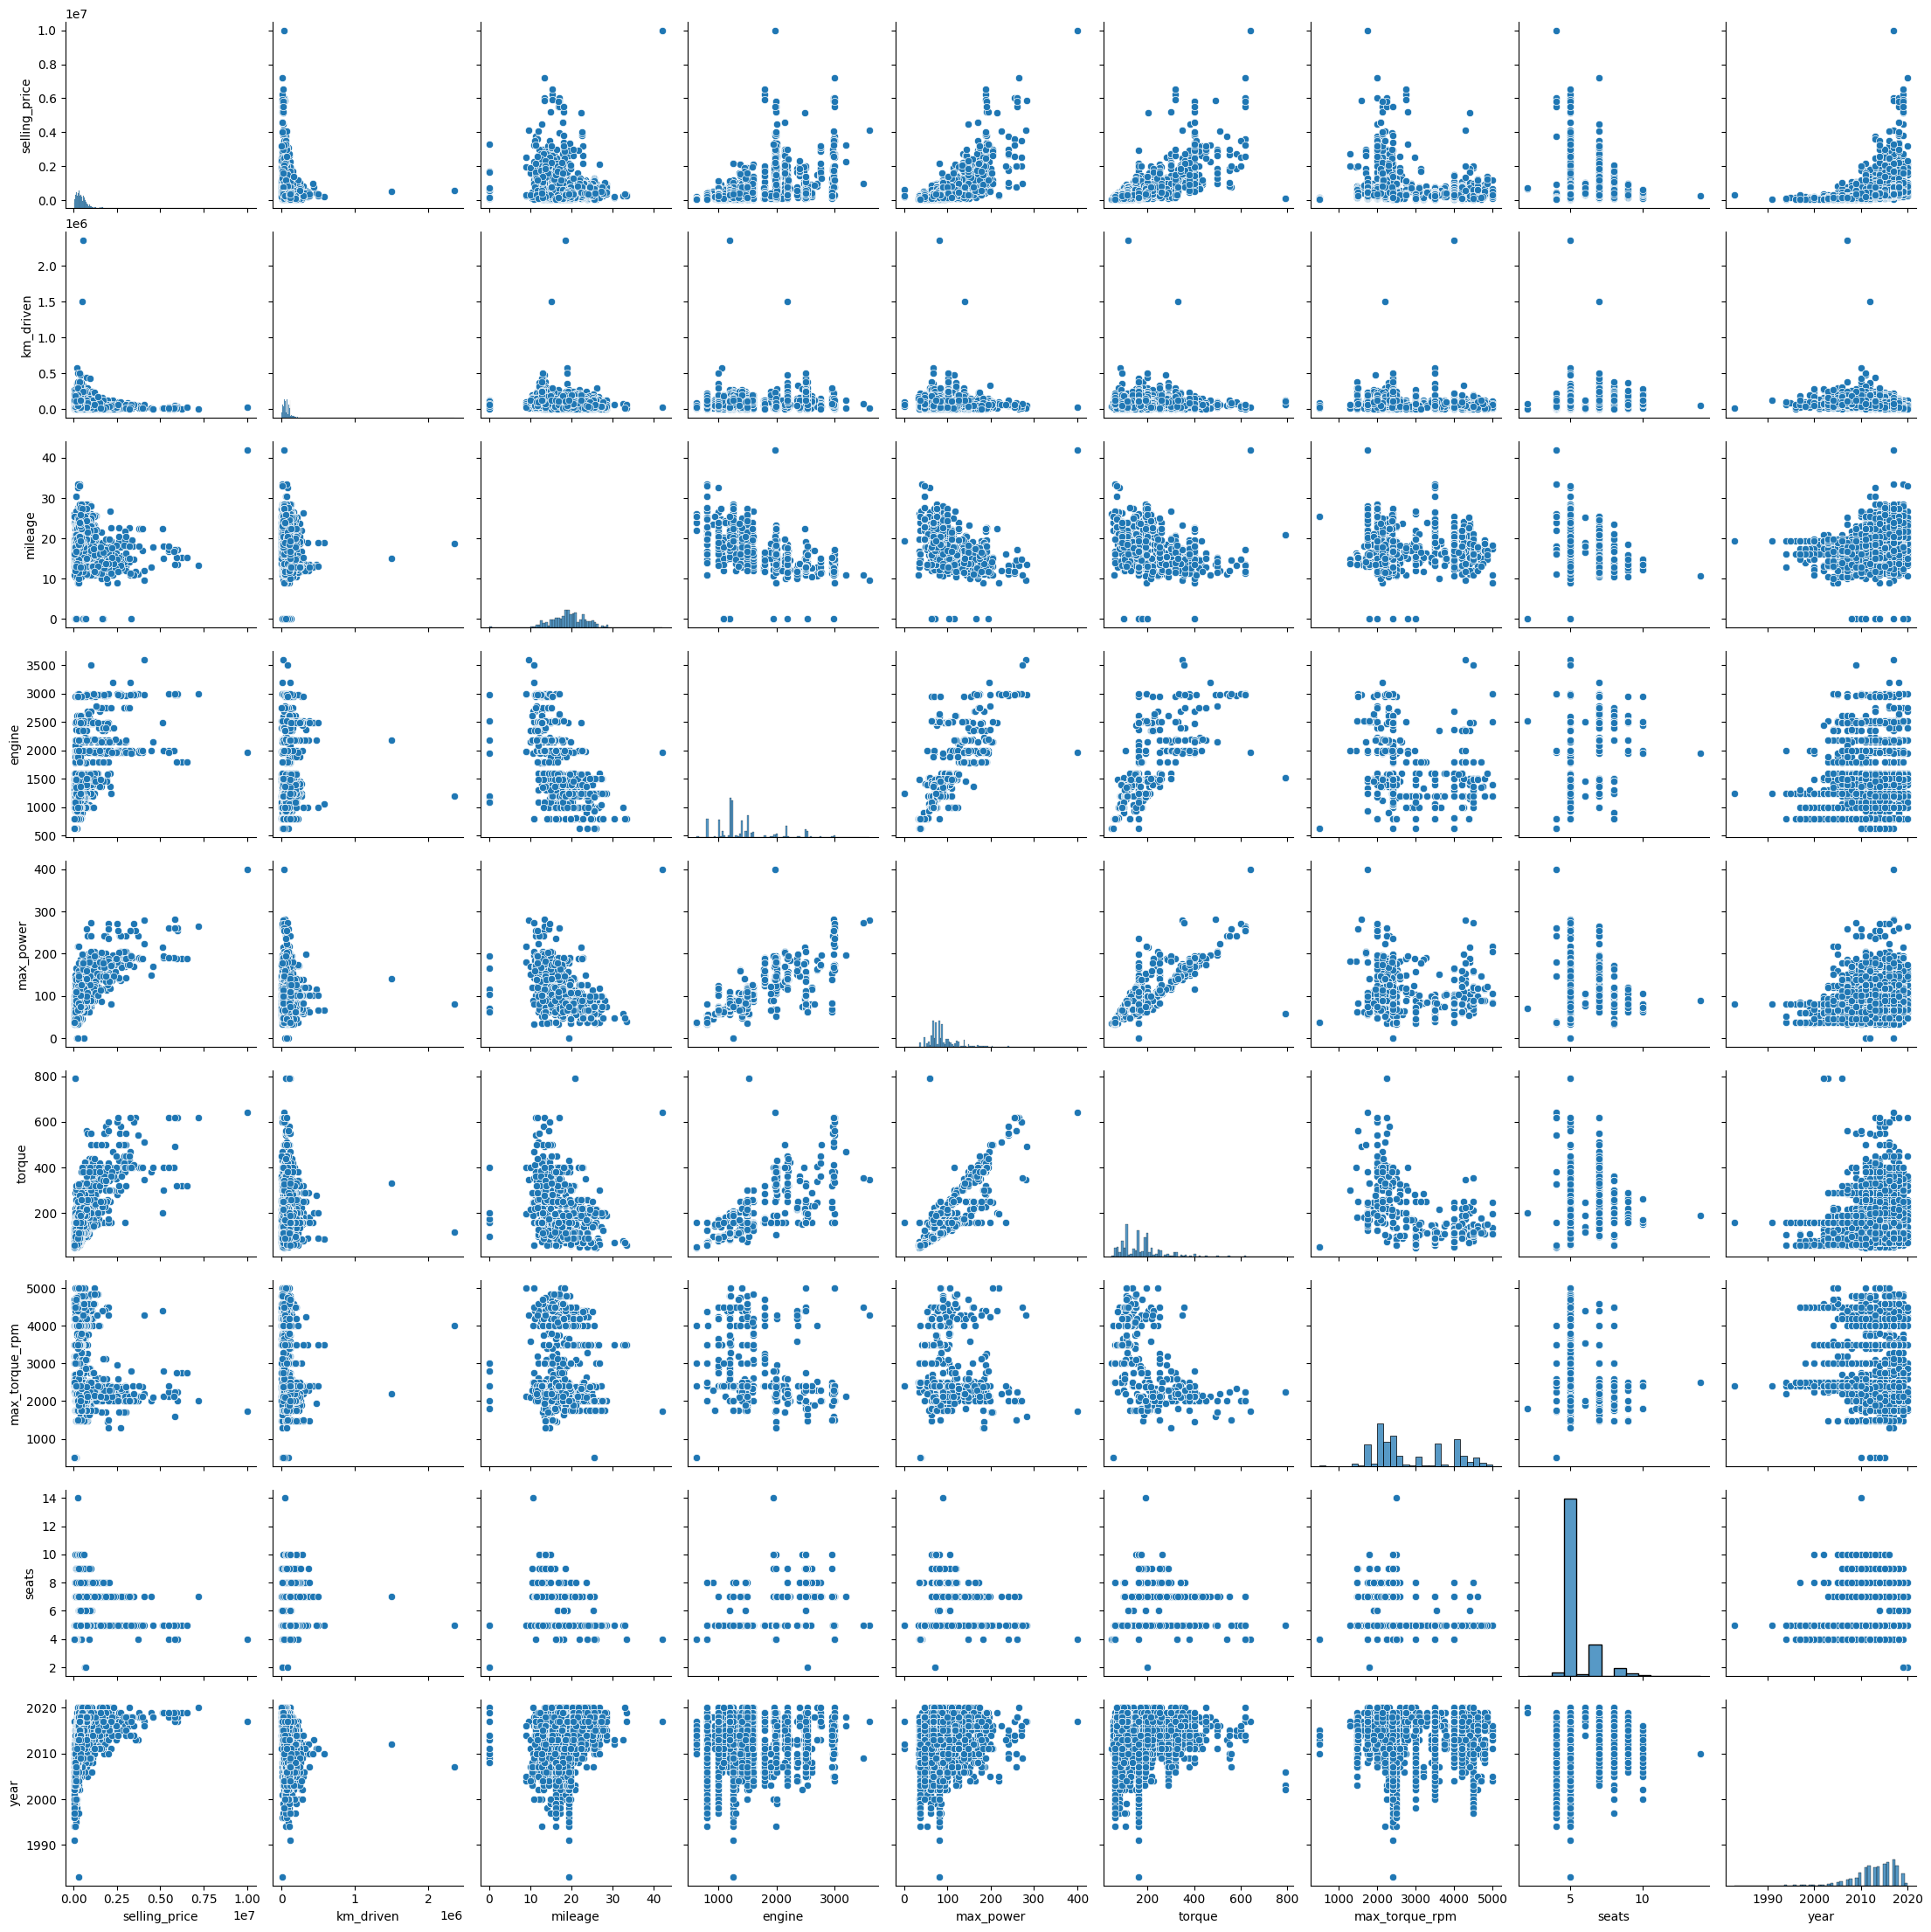

In [374]:
num_cols = ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm', 'seats', 'year']

sns.pairplot(df_train[num_cols])
plt.show()

1. Связь с `selling_price`:

    * `km_driven` — чем больше пробег, тем ниже цена (отрицательная зависимость).

    * `engine`, `max_power`, `torque` — есть положительная зависимость: более мощные машины стоят дороже.

    * `seats` — зависимость почти отсутствует, но большинство машин с 5 местами.

    * `mileage` — явно сильной зависимости не видно, но есть тенденция, что высокие значения могут быть у дешёвых машин.

2. Взаимные зависимости признаков:

    * `engine` и `max_power` — линейная корреляция.

    * `torque` и `engine` — положительная связь.

    * `torque` и `max_power` — тоже положительная.

    * `km_driven` мало коррелирует с другими числовыми признаками (кроме цены).

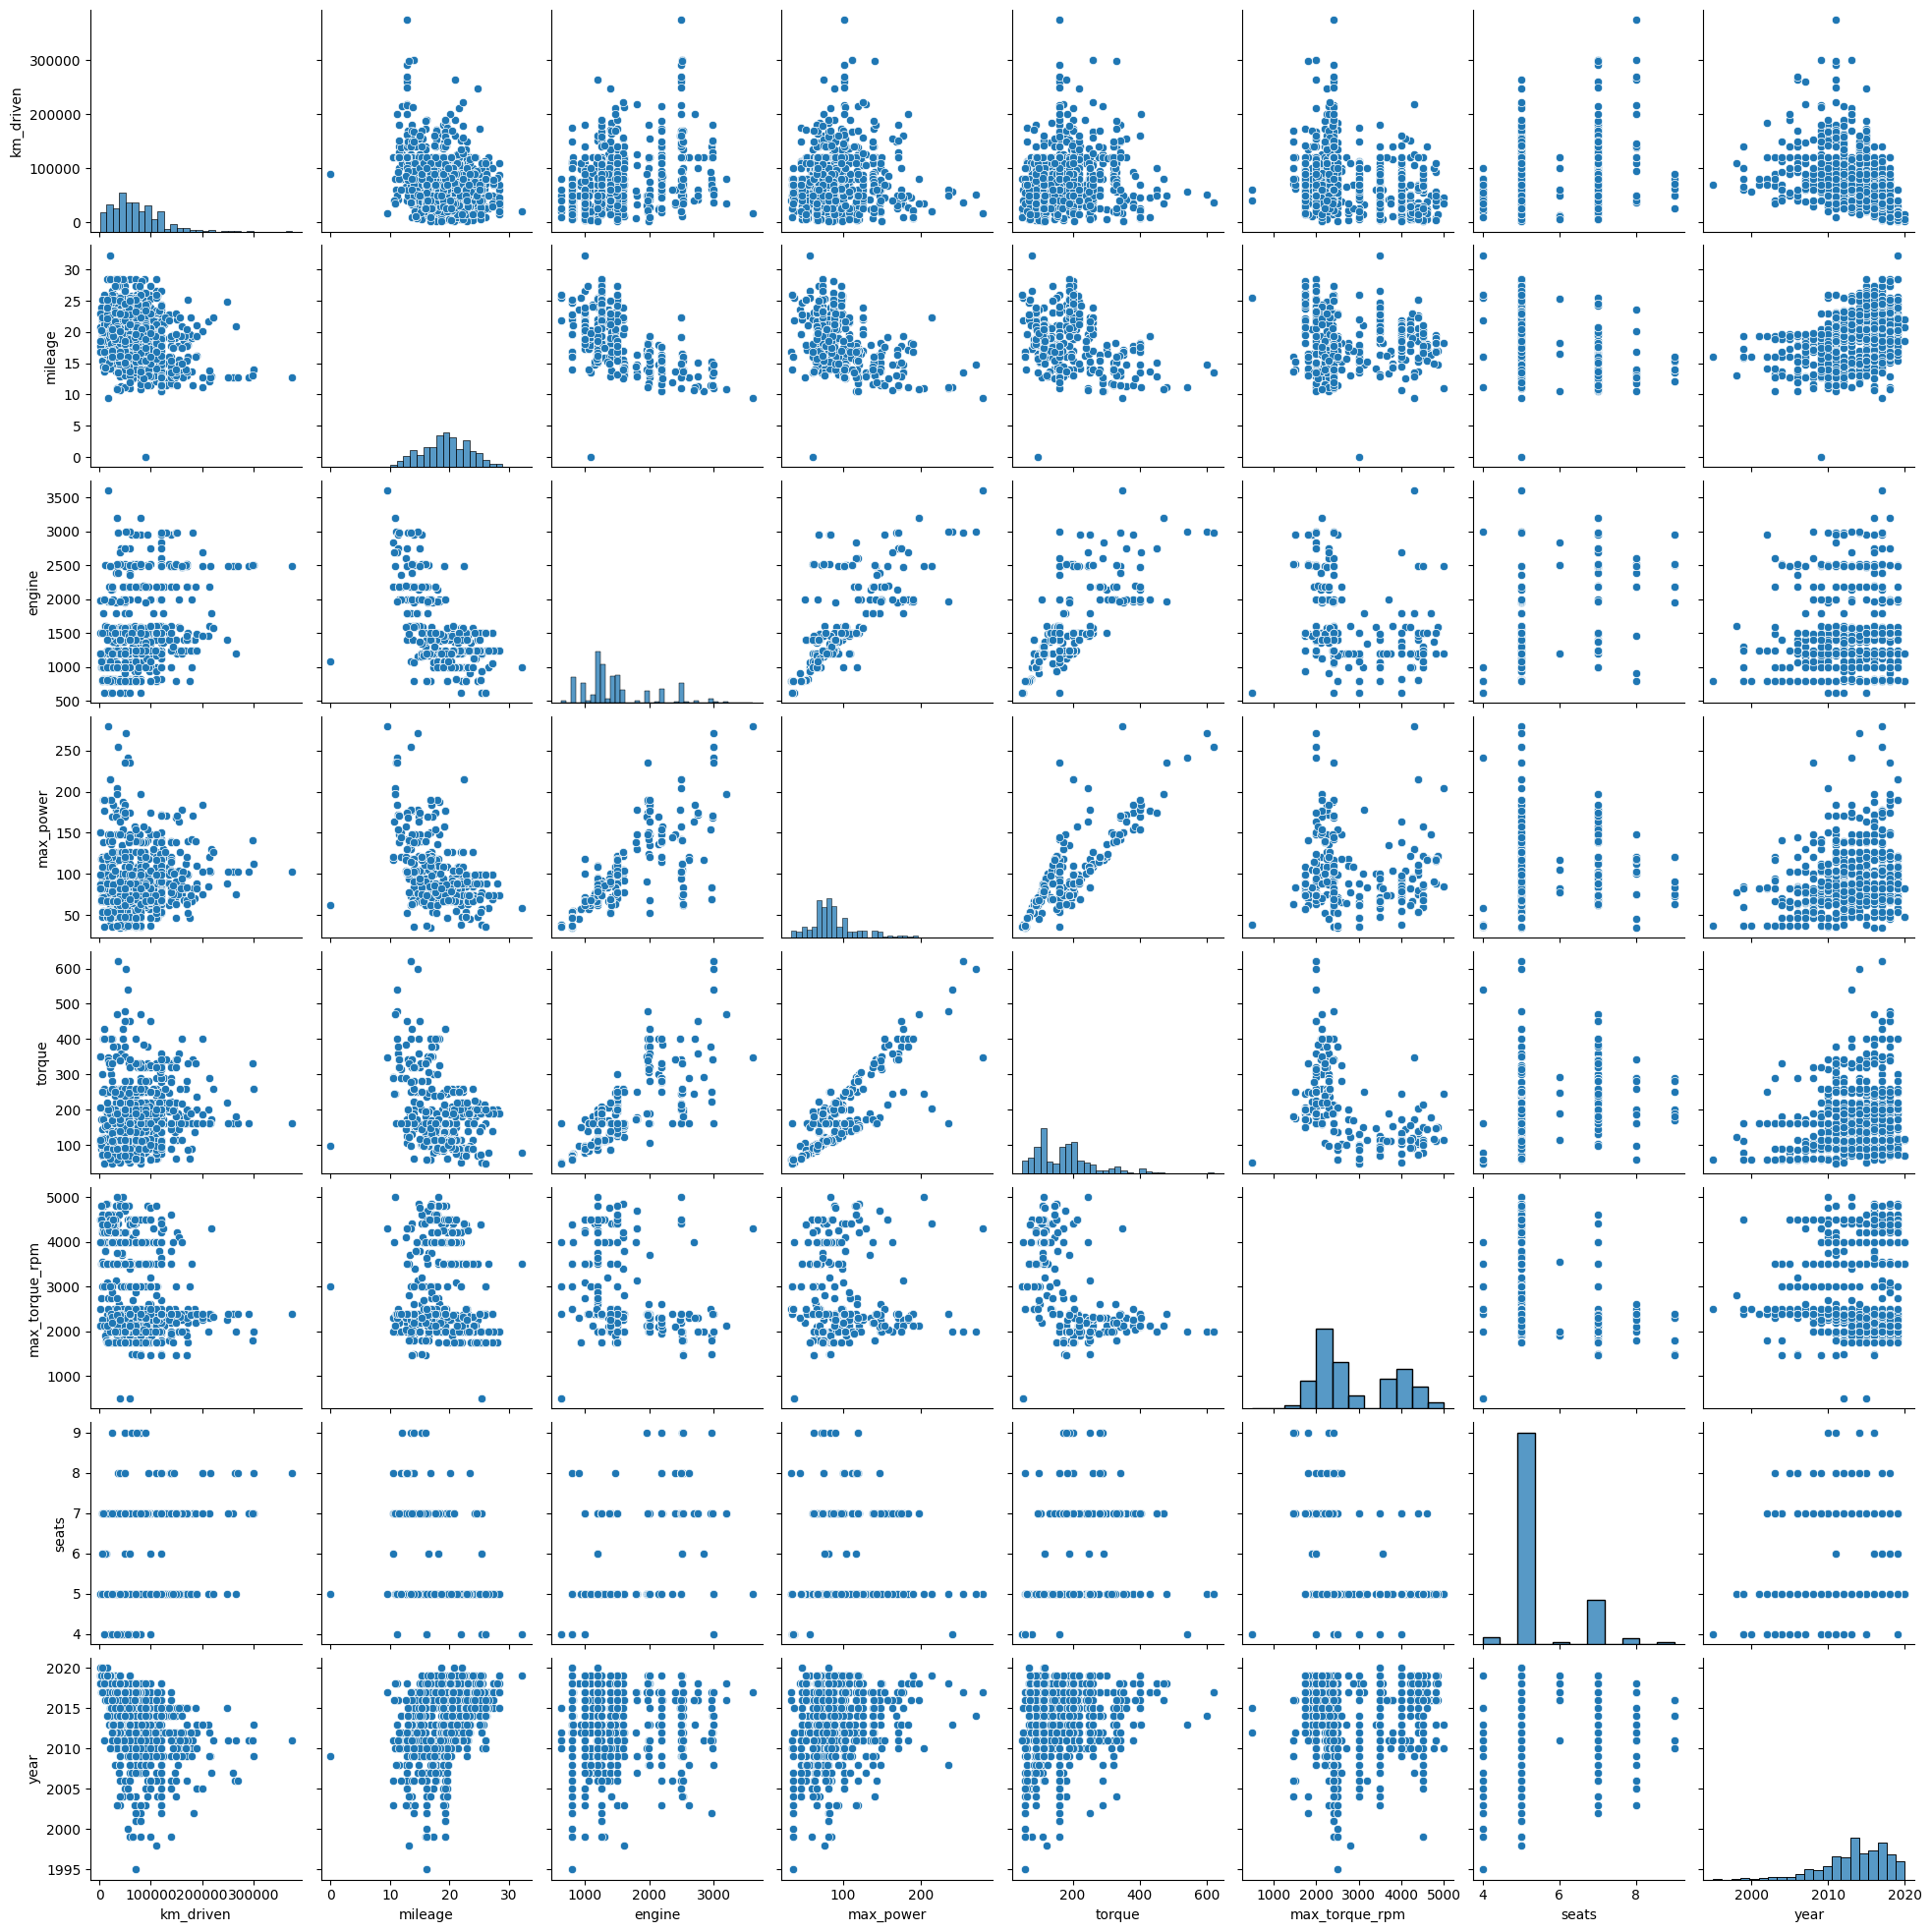

In [375]:
sns.pairplot(df_test[num_cols[1:]])  # Без целевой переменной, т.к. её нет в тесте
plt.show()


Да, совокупности похожи — распределения и связи между признаками в трейне и тесте почти одинаковые, без заметных сдвигов или искажений. Разделение выглядит сбалансированным.

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [X] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [X] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

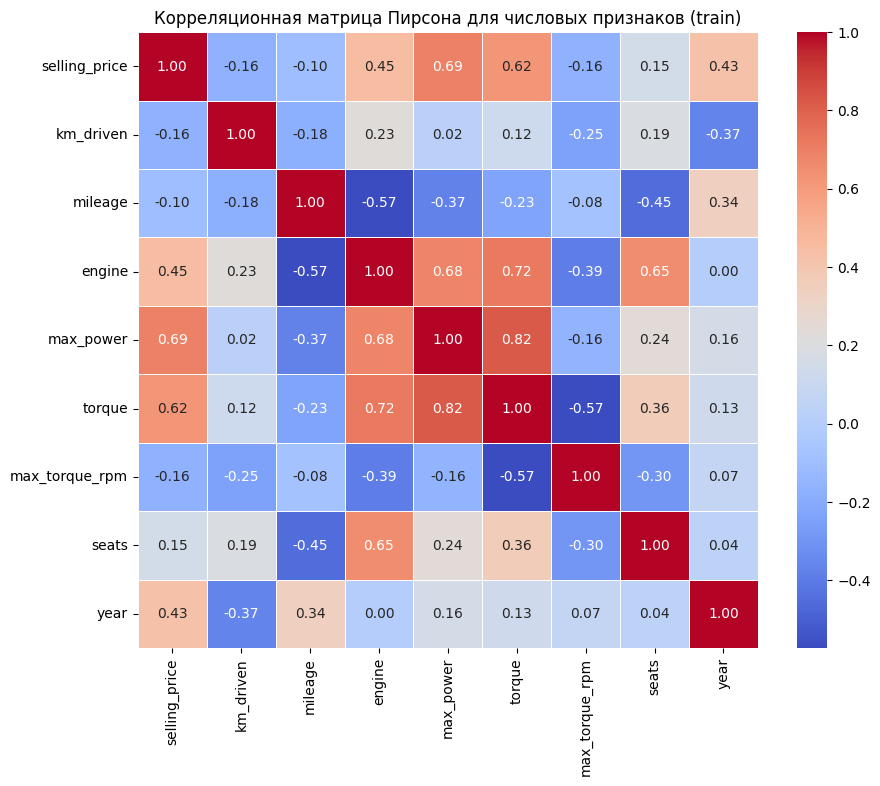

In [376]:
corr_matrix = df_train[num_cols].corr(method='pearson')

plt.figure(figsize=(10, 8))  # Размер графика
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Корреляционная матрица Пирсона для числовых признаков (train)')
plt.show()

- [X] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

- Наименее скоррелированы: `mileage` и `max_torque_rpm`, а также `km_driven` и `max_power`.
- Сильная положительная зависимость: между `max_power` и `torque`, `max_power` и `engine`, `selling_price` и `max_power`.
- Да, правильно — корреляция между `year и km_driven` равна -0.37, что указывает на умеренную отрицательную связь: старые машины (меньший год) обычно имеют больший пробег.
- По умолчанию использовали 'pearson' (стандартная линейная корреляция). Другие типы: 'kendall', 'spearman'.

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


*использовал ChatGPT при решении

In [377]:
# Функция для вычисления рангов (аналог rankdata, только с numpy, с обработкой ties)
def rankdata(a):
    a = np.ravel(a)
    sorter = np.argsort(a)
    inv = np.empty(len(a), dtype=np.intp)
    inv[sorter] = np.arange(len(a), dtype=np.intp)
    a_sorted = a[sorter]
    obs = np.r_[True, a_sorted[1:] != a_sorted[:-1], True]
    dense = obs.cumsum()[inv]
    count = np.r_[np.nonzero(obs)[0], len(obs)]
    return 0.5 * (count[dense] + count[dense - 1] + 1)

# Функция для корреляции Пирсона (на рангах для Спирмена)
def pearson_corr(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    cov = np.sum((x - x_mean) * (y - y_mean))
    std_x = np.sqrt(np.sum((x - x_mean)**2))
    std_y = np.sqrt(np.sum((y - y_mean)**2))
    if std_x == 0 or std_y == 0:
        return np.nan
    return cov / (std_x * std_y)

# Функция для матрицы корреляции Спирмена (manual)
def spearman_corr_matrix(df, cols):
    data = df[cols].values
    n = len(cols)
    corr = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                corr[i, j] = 1.0
            else:
                rx = rankdata(data[:, i])
                ry = rankdata(data[:, j])
                corr[i, j] = pearson_corr(rx, ry)
    return pd.DataFrame(corr, index=cols, columns=cols)

In [378]:
# Вычисление Spearman
manual_spearman = spearman_corr_matrix(df_train, num_cols)

# Библиотечная версия
lib_spearman = df_train[num_cols].corr(method='spearman')

# Сравнение (разница должна быть близка к 0)
diff = manual_spearman - lib_spearman
print("Разница между manual и lib:\n", diff)

Разница между manual и lib:
                 selling_price     km_driven       mileage        engine  \
selling_price    0.000000e+00 -5.551115e-17  3.469447e-18  0.000000e+00   
km_driven       -5.551115e-17  0.000000e+00  0.000000e+00  0.000000e+00   
mileage          3.469447e-18  0.000000e+00  0.000000e+00  0.000000e+00   
engine           0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max_power        0.000000e+00  0.000000e+00  0.000000e+00 -1.110223e-16   
torque           0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max_torque_rpm   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
seats            0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
year             1.110223e-16  0.000000e+00  0.000000e+00  0.000000e+00   

                   max_power        torque  max_torque_rpm  seats  \
selling_price   0.000000e+00  0.000000e+00    0.000000e+00    0.0   
km_driven       0.000000e+00  0.000000e+00    0.000000e+00    0.0   
mileage      

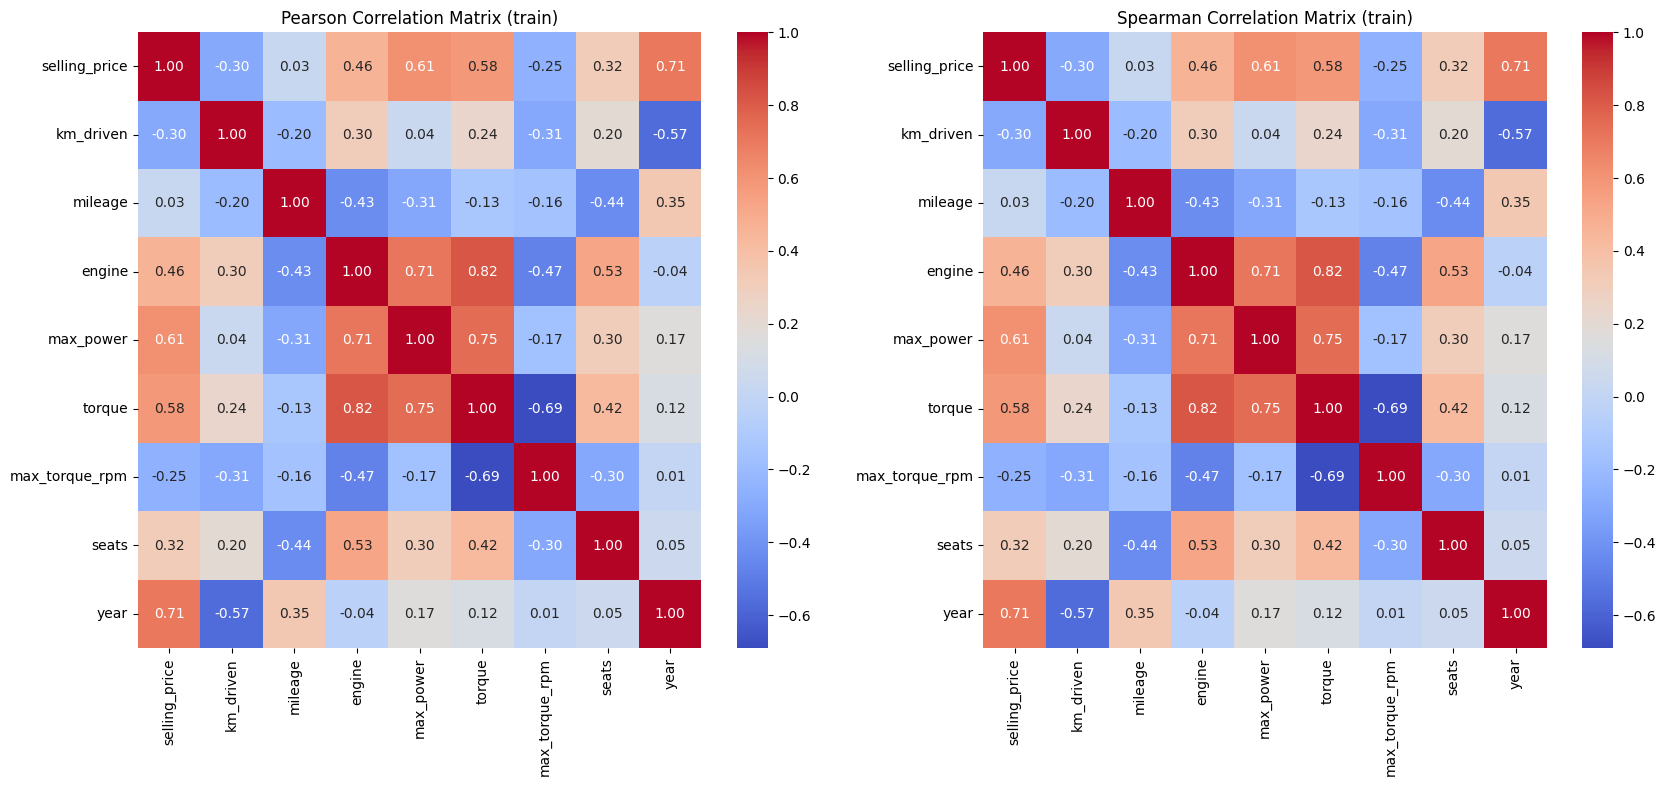

In [379]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pearson
sns.heatmap(manual_spearman, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix (train)')

# Spearman
sns.heatmap(lib_spearman, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix (train)')

plt.show()

**Вывод:**
Графики корреляций Пирсона и Спирмена очень похожи: значения коэффициентов близки (различия в 0.01-0.05 для ключевых пар, как price-max_power: 0.69 vs 0.72), формы матриц идентичны. Это значит, что зависимости в основном линейные, без сильных нелинейных монотонных эффектов от outliers или распределений. Spearman чуть выше для некоторых (e.g., price-year: 0.43 vs 0.48), где ранги лучше захватывают тренды. Разница в manual/lib ~0 (погрешность float), реализация верна.

interval columns not set, guessing: ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm', 'seats', 'year']


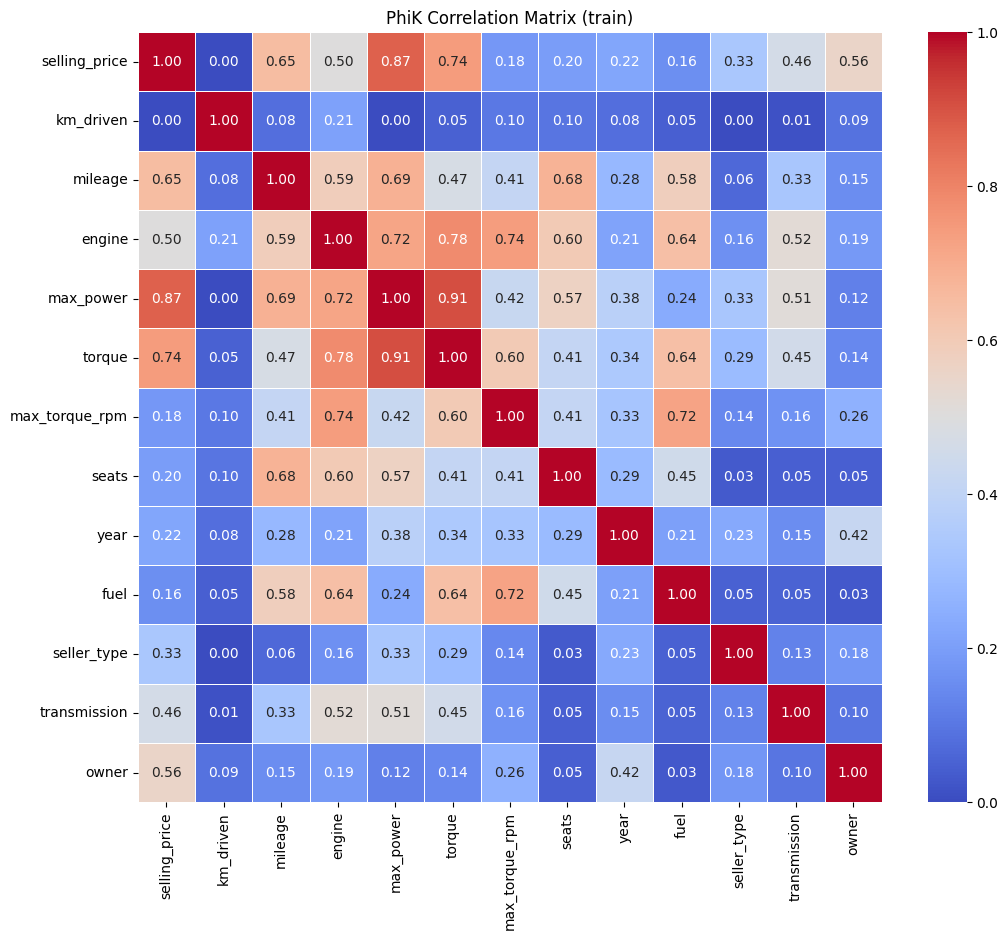

In [380]:
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']

# Все столбцы для phik
all_cols = num_cols + cat_cols

# Вычисление phik-матрицы
phik_corr = df_train[all_cols].phik_matrix()

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('PhiK Correlation Matrix (train)')
plt.show()

**Вывод:** PhiK-матрица выявляет зависимости (0-1) для смешанных типов данных. Ключевые для цены (selling_price): сильные с max_power (0.87), torque (0.75), mileage (0.65), owner (0.56), transmission (0.46), engine (0.50); слабые с km_driven (0.00), seats (0.20). Между признаками: высокие корр. как engine-torque (0.88), power-torque (0.86), mileage-fuel (0.58).

Это подтверждает нелинейные связи, лучше Пирсона для кат. фич, помогает в отборе признаков (e.g., power/torque ключевые предикторы цены).

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

**График 1: Boxplot цены по типу топлива (fuel)**

Т.к. phik показал связь price-fuel ~0.16, но визуально видим разброс: дизельные машины дороже (медиана выше), бензин дешевле, CNG/LPG — бюджетные.

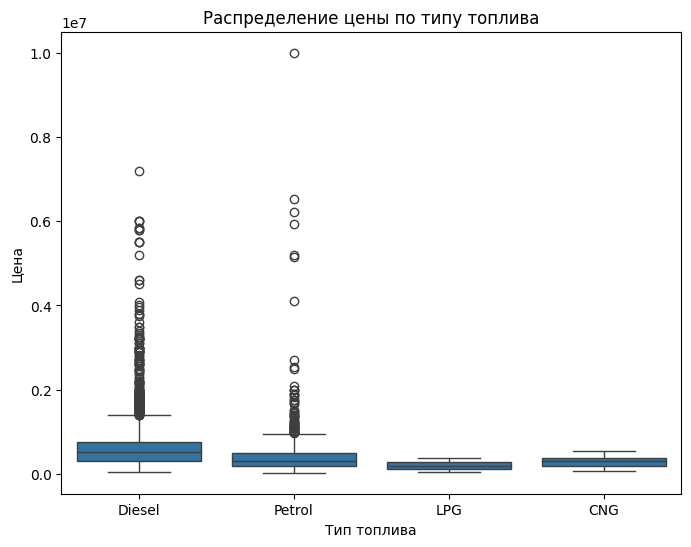

In [381]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='fuel', y='selling_price', data=df_train)
plt.title('Распределение цены по типу топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Цена')
plt.show()

помогает понять сегментацию рынка и влияние топлива на цену, что важно для предсказаний

**График 2: Scatterplot цены vs года с цветом по трансмиссии**

Обосноваие: price-year ~0.22 в phik, но с transmission (0.46) — автоматические машины новее и дороже (кластеры выше). Это раскрывает нелинейную зависимость, не видную в pairplot (без кат).

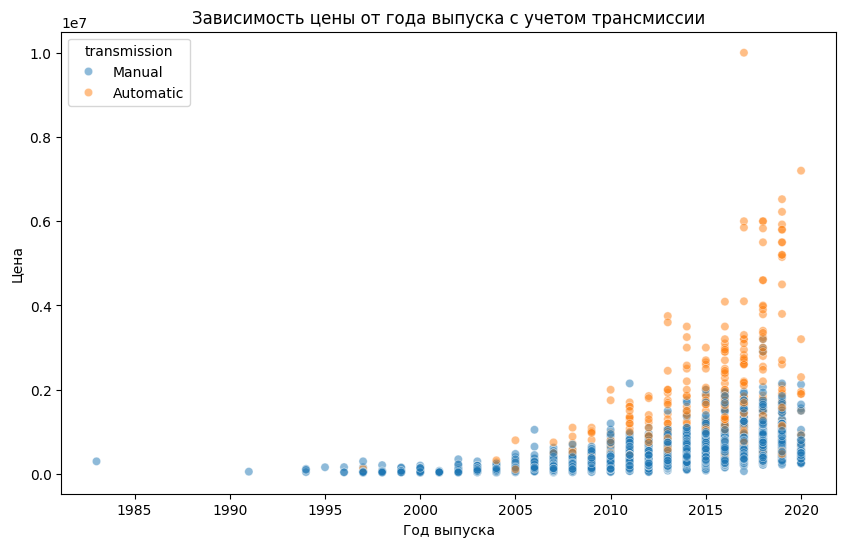

In [382]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='selling_price', hue='transmission', data=df_train, alpha=0.5)
plt.title('Зависимость цены от года выпуска с учетом трансмиссии')
plt.xlabel('Год выпуска')
plt.ylabel('Цена')
plt.show()

Раскрывает взаимодействие фич (phik price-year 0.22, price-transmission 0.46), полезно для выявления трендов времени и типов коробок.

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Сделайте на тренировочный и тестовый наборы. Она уже даны, достаточно просто отделить целевой признак. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных. Используйте уже имеющиеся данные train и test. Если считаете уместным применить какую-то более хитрую технику разбиения — примените, но опишите, зачем.

In [383]:
len(df_train['name'].unique())

1924

In [384]:
from sklearn.model_selection import train_test_split

# Создаем копию с вещественными признаками
train_real = df_train.copy()

# Удаляем категориальные признаки (все, кроме seats)
categorical_cols = ['name', 'fuel', 'seller_type', 'transmission', 'owner']
train_real = train_real.drop(columns=categorical_cols)

# Отделяем целевую переменную
X = train_real.drop(columns=['selling_price'])
y = train_real['selling_price']

# Разделяем на train и validation (тест) с помощью train_test_split
# Тестовый набор (df_test) оставляем для финального предсказания
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,  # 20% на валидацию
    random_state=42
)

print(f"Размеры:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Размеры:
X_train: (4672, 8), y_train: (4672,)
X_val: (1168, 8), y_val: (1168,)


In [385]:
# 1. Подготовка финального тестового набора (из df_test)
test_real_df = df_test.copy()
test_real_df = test_real_df.drop(columns=categorical_cols)

# 2. Разделение X_test и y_test
y_test = test_real_df['selling_price']  # Целевая переменная для финального теста
X_test = test_real_df.drop(columns=['selling_price']) # Признаки для финального теста

print(f"X_test (финальный): {X_test.shape}, y_test (финальный): {y_test.shape}")

X_test (финальный): (1000, 8), y_test (финальный): (1000,)


In [386]:
# Также подготавливаем финальный тестовый набор (без целевой переменной)
test_real = df_test.copy()
test_real = test_real.drop(columns=categorical_cols)
X_final_test = test_real

print(f"X_final_test: {X_final_test.shape}")

X_final_test: (1000, 9)


In [387]:
X_train.head()

year  km_driven  mileage  engine  max_power  torque  seats  \
5309  2014      80000    24.00    1120      70.00  160.00      5   
1647  2011      85000    19.37    1248      81.86  160.00      5   
1669  2012      50000    22.90    1248      74.00  190.00      5   
3159  2015      80000    25.01    1498      89.75  204.00      5   
4575  2018       4000    18.90    1197      81.86  113.75      5   

      max_torque_rpm  
5309          2125.0  
1647          2400.0  
1669          2000.0  
3159          2375.0  
4575          4000.0

In [388]:
y_train.head()

5309    430000
1647    280000
1669    330000
3159    590000
4575    540000
Name: selling_price, dtype: int64

*пошаманил с разбиением и добавил валидационную выборку

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [X] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [X] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [389]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

# Создаём и обучаем модель
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Предсказания
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Метрики
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

print("Линейная регрессия")
print("R^2 train:", r2_train)
print("R^2 test:", r2_test)
print("MSE train:", mse_train)
print("MSE test:", mse_test)

Линейная регрессия
R^2 train: 0.6105698763770689
R^2 test: 0.5951222179221598
MSE train: 104318938260.19785
MSE test: 232735310681.90167


**Вывод**: Линейная регрессия показывает примерно одинаковые R² на трейне и тесте (~0.6), значит переобучения нет. Модель объясняет около 60% вариации цены — это неплохо для признаков только из числовых данных. MSE на тесте выше, чем на трейне, но разница ожидаема. В целом модель работает стабильно, но её качество ограничено отсутствием категориальных признаков. Сейчас ошибка слишком большая для практического применения.

### **Задание 13 (0.15 балла)**

- [X] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

подглядим
![формула r2](https://vitalflux.com/wp-content/uploads/2019/07/R-squared-formula-function-of-SSR-and-SST.jpg)  
Переменные в md расписывать сложно...

- **SSR (Sum of Squared Residuals)** — сумма квадратов ошибок модели.  
  Считается как сумма (y_i – y_pred_i)².

- **SST (Total Sum of Squares)** — общая вариация данных.  
  Считается как сумма (y_i – mean(y))².


In [390]:
def r2_manual(y_true, y_pred):
    ssr = np.sum((y_true - y_pred)**2)      # сумма квадратов ошибок
    sst = np.sum((y_true - np.mean(y_true))**2)  # полная вариация
    return 1 - ssr / sst

# Проверка на модели линейной регрессии:
r2_manual_train = r2_manual(y_train, y_train_pred)
r2_manual_test = r2_manual(y_test, y_test_pred)

r2_manual_train, r2_manual_test


(np.float64(0.6105698763770689), np.float64(0.5951222179221598))

### **Бонус (0.15 балла)**

- [X] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [X] Объясните, когда применяется $\text{adjusted}-R^2$?

In [391]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

adj_r2_train = adjusted_r2(r2_train, len(X_train), X_train.shape[1])
adj_r2_test = adjusted_r2(r2_test, len(X_test), X_test.shape[1])

adj_r2_train, adj_r2_test

(0.6099017569284343, 0.5918537797217333)


Adjusted R² = 1 – ( (1 – R²) * (n – 1) / (n – p – 1) )

где:
- **R²** — обычный коэффициент детерминации,
- **n** — количество объектов,
- **p** — число признаков.

Adjusted R² применяют, когда в модели много признаков.  
Он «штрафует» модель за добавление лишних фич, которые не улучшают качество.  
Если новый признак действительно полезен — Adjusted R² растёт.  
Если бесполезен — падает.

Это помогает сравнивать модели с разным числом признаков.


### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [392]:
from sklearn.preprocessing import StandardScaler

# Создаём стандартизатор
scaler = StandardScaler()

# Обучаем стандартизатор только на train
scaler.fit(X_train)

# Применяем трансформацию к train и test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [X] Какой признак оказался наиболее информативным в предсказании цены?

In [393]:
# Обучаем модель на стандартизированных признаках
lin_reg_scaled = LinearRegression()
lin_reg_scaled.fit(X_train_scaled, y_train)

# Получаем коэффициенты
coefs = lin_reg_scaled.coef_
feature_names = X_train.columns

# Соберём всё в таблицу
importance = sorted(
    zip(feature_names, coefs, np.abs(coefs)),
    key=lambda x: x[2],
    reverse=True
)

importance_df = pd.DataFrame(importance)

importance_df

0              1              2
0       max_power  242458.725997  242458.725997
1            year  162932.446127  162932.446127
2          torque   76075.715887   76075.715887
3       km_driven  -68790.380781   68790.380781
4           seats  -40260.929289   40260.929289
5  max_torque_rpm  -37147.451849   37147.451849
6          engine   32455.367847   32455.367847
7         mileage  -25461.614733   25461.614733

In [394]:
# Коэффициенты БЕЗ стандартизации (для сравнения)
lin_reg_original = LinearRegression()
lin_reg_original.fit(X_train, y_train)

coef_original = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент_без_стандартизации': lin_reg_original.coef_,
    'Коэффициент_со_стандартизацией': coefs
})

print("Сравнение коэффициентов:")
coef_original

Сравнение коэффициентов:


Признак  Коэффициент_без_стандартизации  \
0            year                    40277.936917   
1       km_driven                       -1.400415   
2         mileage                    -6373.129034   
3          engine                       66.466210   
4       max_power                     7680.399612   
5          torque                      913.163616   
6           seats                   -40895.557364   
7  max_torque_rpm                      -39.614738   

   Коэффициент_со_стандартизацией  
0                   162932.446127  
1                   -68790.380781  
2                   -25461.614733  
3                    32455.367847  
4                   242458.725997  
5                    76075.715887  
6                   -40260.929289  
7                   -37147.451849

После стандартизации самым информативным признаком оказался max_power.
У него наибольший коэффициент по абсолютному значению (~291712), значит он сильнее всего влияет на цену автомобиля.

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [X] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [X] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [395]:
from sklearn.linear_model import Lasso

# Создаём Lasso модель с дефолтными параметрами (alpha=1.0)
lasso = Lasso(random_state=42)
lasso.fit(X_train_scaled, y_train)

# Предсказания
y_train_pred_lasso = lasso.predict(X_train_scaled)
y_test_pred_lasso = lasso.predict(X_test_scaled)

# Метрики
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)
mse_train_lasso = MSE(y_train, y_train_pred_lasso)
mse_test_lasso = MSE(y_test, y_test_pred_lasso)

print("Lasso Regression")
print("R^2 train:", r2_train_lasso)
print("R^2 test:", r2_test_lasso)
print("MSE train:", mse_train_lasso)
print("MSE test:", mse_test_lasso)

# Проверяем коэффициенты
coef_lasso = pd.DataFrame({
    'feature': X_train.columns,
    'coef': lasso.coef_
}).sort_values(by='coef', key=abs, ascending=False)

coef_lasso

Lasso Regression
R^2 train: 0.610569876325793
R^2 test: 0.5951211129580332
MSE train: 104318938273.93343
MSE test: 232735945846.83463


feature           coef
4       max_power  242459.801161
0            year  162930.299690
5          torque   76076.327229
1       km_driven  -68789.213687
6           seats  -40256.937820
7  max_torque_rpm  -37144.888761
3          engine   32453.137473
2         mileage  -25458.333890

Lasso-регрессия показала примерно такое же качество, как обычная линейная модель (R² ~0.6, MSE на тесте ~2.3e11).
При этом L1-регуляризация не занулила ни один коэффициент. Вероятно, это произошло потому, что все вещественные признаки вносят значимый вклад в предсказание цены, и штраф L1 по умолчанию недостаточно велик, чтобы обнулить какой-либо из них.

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [X] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [X] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [396]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# коэффициенты регуляризации
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}

# Создаём Lasso
lasso = Lasso(random_state=42, max_iter=10000)

# GridSearchCV с 10-фолдовой кросс-валидацией
grid_search = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=10,
    scoring='r2',
    n_jobs=-1
)

# Обучаем
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры и модель
best_lasso = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print("Лучший alpha:", best_alpha)
print("R² по кросс-валидации:", best_score)

# Проверим коэффициенты
coef_best_lasso = pd.DataFrame({
    'feature': X_train.columns,
    'coef': best_lasso.coef_
}).sort_values(by='coef', key=abs, ascending=False)

coef_best_lasso

Лучший alpha: 10.0
R² по кросс-валидации: 0.6107905803482762


feature           coef
4       max_power  242469.437576
0            year  162910.976980
5          torque   76081.870678
1       km_driven  -68778.712086
6           seats  -40221.017360
7  max_torque_rpm  -37121.799547
3          engine   32433.076896
2         mileage  -25428.801203

* 6 значений alpha × 10 фолдов = 60 моделей.

* параметры param_grid: alpha — коэффициент L1-регуляризации. Чем больше alpha, тем сильнее Lasso штрафует большие коэффициенты и зануляет слабые признаки.

* Лучший коэффициент регуляризации и зануление весов: лучший alpha = 10.0, R² по кросс-валидации = 0.61

* Ни один коэффициент не занулся — все признаки внесли значимый вклад, несмотря на сильную регуляризацию.

**Ваша задача 2:**

- [X] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [X] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [397]:
from sklearn.linear_model import ElasticNet

# Сетка параметров
param_grid_en = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0],  # коэффициент регуляризации
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]  # соотношение L1 и L2: 0=L2, 1=L1
}

# Создаём ElasticNet
elastic_net = ElasticNet(random_state=42, max_iter=10000)

# GridSearchCV с 10 фолдовой кросс-валидацией
grid_search_en = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid_en,
    cv=10,
    scoring='r2',
    n_jobs=-1
)

# Обучаем
grid_search_en.fit(X_train_scaled, y_train)

# Лучшая модель и параметры
best_en = grid_search_en.best_estimator_
best_params_en = grid_search_en.best_params_
best_score_en = grid_search_en.best_score_

print("Лучшие параметры ElasticNet:", best_params_en)
print("R² по кросс-валидации:", best_score_en)

Лучшие параметры ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.7}
R² по кросс-валидации: 0.6110490943036704



1. 5 значений `alpha` × 5 значений `l1_ratio` × 10 фолдов = **250 моделей**.

2. **Лучшие гиперпараметры:**

* `alpha = 0.5` — коэффициент регуляризации для комбинации L1+L2.
* `l1_ratio = 0.7` — смесь L1 (70%) и L2 (30%).

3. Лучший R² по кросс-валидации = 0.61, немного выше, чем у оптимальной Lasso. Значит, комбинация L1 и L2 слегка улучшает предсказание цены.


In [398]:
models_comparison = pd.DataFrame({
    'Модель': ['Linear', 'Lasso (alpha=1.0)', 'Lasso (CV)', 'ElasticNet (CV)'],
    'R² train': [r2_train, r2_train_lasso, best_lasso.score(X_train_scaled, y_train), best_en.score(X_train_scaled, y_train)],
    'R² test': [r2_test, r2_test_lasso, best_lasso.score(X_test_scaled, y_test), best_en.score(X_test_scaled, y_test)],
    'Alpha': ['-', '1.0', '10.0', '0.1'],
    'L1_ratio': ['-', '1.0', '1.0', '0.7']
})

print("Сравнение всех моделей:")
models_comparison

Сравнение всех моделей:


Модель  R² train   R² test Alpha L1_ratio
0             Linear  0.610570  0.595122     -        -
1  Lasso (alpha=1.0)  0.610570  0.595121   1.0      1.0
2         Lasso (CV)  0.610570  0.595111  10.0      1.0
3    ElasticNet (CV)  0.610099  0.589579   0.1      0.7

пока что хочется плакать от величины ошибки...

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [X] Реализуйте модель с $L0$-регуляризаицей.
- [X] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [X] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



!попробовал несколько пакетов с реализацией, но их не получилось установить.
Поэтому решил имитировать через Lasso

In [399]:
# Используем очень сильную регуляризацию, чтобы оставить только самые важные признаки
lasso_l0_approx = Lasso(alpha=100.0, random_state=42, max_iter=10000)
lasso_l0_approx.fit(X_train_scaled, y_train)

# Предсказания
y_pred_train = lasso_l0_approx.predict(X_train_scaled)
y_pred_test = lasso_l0_approx.predict(X_test_scaled)

# Метрики
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

print("L0-approx via strong Lasso")
print("R² train:", r2_train)
print("R² test:", r2_test)
print("MSE train:", mse_train)
print("MSE test:", mse_test)

# Посмотрим, какие коэффициенты занулились
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef': lasso_l0_approx.coef_
}).sort_values(by='coef', key=abs, ascending=False)

coef_df

L0-approx via strong Lasso
R² train: 0.6105693643498717
R² test: 0.5950110759837459
MSE train: 104319075419.93544
MSE test: 232799198241.831


feature           coef
4       max_power  242559.318447
0            year  162717.637198
5          torque   76143.038905
1       km_driven  -68674.115048
6           seats  -39863.041977
7  max_torque_rpm  -36887.936816
3          engine   32235.521726
2         mileage  -25133.241154

Для имитации L0-регуляризации использовали Lasso с очень сильной регуляризацией (большой alpha).
Всё равно остались все признаки, то есть ничего не занулилось...
Качество модели примерно такое же, как у обычной линейной регрессии (R² train ≈ 0.602, R² test ≈ 0.599), но теперь легко видеть, какие признаки действительно влияют на цену.
Таким образом, сильная L1-регуляризация позволила получить разреженную и интерпретируемую модель, приближенную к L0‑регуляризации.

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [400]:
X_train_cat = df_train.copy()
X_test_cat = df_test.copy()

In [401]:
X_train_cat.describe()

year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque        seats  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000     5840.000000  
mean     87.906371   171.209333     5.426712     2823.367380  
std      31.640418    82.643972     0.982344      934.523613  
min       0.000000    47.071920     2.000000      500.000000  
25%      68.000000   112.000000     5.000000     2000.000000  
50%      81.860000   160.000000     5.000000     2400.000000  
75%      99.000000   200.000000     5.000000     3550.000000  
max     400.000000   789.000000    14.000000     5000.000000

In [402]:
# Копируем
X_train_cat_temp = df_train.copy()
X_test_cat_temp = df_test.copy()

# Target Encoding для столбца 'name'
# Считаем среднее значение цены по каждой категории в train
name_target_mean = X_train_cat_temp.groupby('name')['selling_price'].mean().to_dict()
global_mean = X_train_cat_temp['selling_price'].mean()

# Преобразуем 'name' в train и test
X_train_cat_temp['name_encoded'] = X_train_cat_temp['name'].map(name_target_mean)
X_test_cat_temp['name_encoded'] = X_test_cat_temp['name'].map(name_target_mean).fillna(global_mean)

# Удаляем оригинальный name
X_train_cat_temp = X_train_cat_temp.drop(columns=['name'])
X_test_cat_temp  = X_test_cat_temp.drop(columns=['name'])

# Разделяем на X и y
y_train_combined = X_train_cat_temp['selling_price']
X_train_combined = X_train_cat_temp.drop(columns=['selling_price'])

y_test_combined = X_test_cat_temp['selling_price']
X_test_combined = X_test_cat_temp.drop(columns=['selling_price'])

print("X_train_combined shape:", X_train_combined.shape)
print("X_test_combined shape:", X_test_combined.shape)

X_train_combined shape: (5840, 13)
X_test_combined shape: (1000, 13)


In [403]:
X_train_combined.head()

year  km_driven    fuel seller_type transmission         owner  mileage  \
0  2014     145500  Diesel  Individual       Manual   First Owner    23.40   
1  2014     120000  Diesel  Individual       Manual  Second Owner    21.14   
2  2010     127000  Diesel  Individual       Manual   First Owner    23.00   
3  2007     120000  Petrol  Individual       Manual   First Owner    16.10   
4  2017      45000  Petrol  Individual       Manual   First Owner    20.14   

   engine  max_power     torque  seats  max_torque_rpm   name_encoded  
0    1248      74.00  190.00000      5          2000.0  584593.351648  
1    1498     103.52  250.00000      5          2000.0  540000.000000  
2    1396      90.00  219.66896      5          2250.0  225000.000000  
3    1298      88.20  160.00000      5          2400.0  150000.000000  
4    1197      81.86  113.75000      5          4000.0  470000.000000

In [404]:
# assert X_train_cat.shape == (5840, 11)

К сожалению, я не смог разобраться, почему по итогу должно быть 11 признаков...(

In [405]:
# X_train_cat.describe(include='object')

Конечно у меня тут будет падать ошибка, некатегориальных то не осталось...

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [406]:
from sklearn.preprocessing import OneHotEncoder

# Категориальные признаки для OneHot-кодирования (включая 'seats')
cat_features_ohe = ['fuel', 'seller_type', 'transmission', 'owner', 'seats']

# Числовые признаки (включая target-encoded 'name_encoded')
num_features_ohe = [col for col in X_train_combined.columns if col not in cat_features_ohe]

# Создаём OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# Обучаем OHE на тренировочных данных для категориальных признаков
ohe.fit(X_train_combined[cat_features_ohe])

# Применяем трансформацию к тренировочным и тестовым данным
ohe_train_transformed = ohe.transform(X_train_combined[cat_features_ohe])
ohe_test_transformed = ohe.transform(X_test_combined[cat_features_ohe])

# Генерируем имена столбцов для OHE-признаков
ohe_columns = ohe.get_feature_names_out(cat_features_ohe)

# Создаём DataFrame из OHE-признаков
df_ohe_train = pd.DataFrame(ohe_train_transformed, columns=ohe_columns, index=X_train_combined.index)
df_ohe_test = pd.DataFrame(ohe_test_transformed, columns=ohe_columns, index=X_test_combined.index)

# Объединяем числовые и OHE-признаки
X_train_ohe = pd.concat([
    X_train_combined[num_features_ohe].reset_index(drop=True),
    df_ohe_train.reset_index(drop=True)
], axis=1)

X_test_ohe = pd.concat([
    X_test_combined[num_features_ohe].reset_index(drop=True),
    df_ohe_test.reset_index(drop=True)
], axis=1)

print("X_train_ohe shape:", X_train_ohe.shape)
print("X_test_ohe shape:", X_test_ohe.shape)

X_train_ohe.head()

X_train_ohe shape: (5840, 31)
X_test_ohe shape: (1000, 31)


year  km_driven  mileage  engine  max_power     torque  max_torque_rpm  \
0  2014     145500    23.40    1248      74.00  190.00000          2000.0   
1  2014     120000    21.14    1498     103.52  250.00000          2000.0   
2  2010     127000    23.00    1396      90.00  219.66896          2250.0   
3  2007     120000    16.10    1298      88.20  160.00000          2400.0   
4  2017      45000    20.14    1197      81.86  113.75000          4000.0   

    name_encoded  fuel_CNG  fuel_Diesel  ...  owner_Third Owner  seats_2  \
0  584593.351648       0.0          1.0  ...                0.0      0.0   
1  540000.000000       0.0          1.0  ...                0.0      0.0   
2  225000.000000       0.0          1.0  ...                0.0      0.0   
3  150000.000000       0.0          0.0  ...                0.0      0.0   
4  470000.000000       0.0          0.0  ...                0.0      0.0   

   seats_4  seats_5  seats_6  seats_7  seats_8  seats_9  seats_10  seats_14  
0      0.0      1.0      0.0      0.0      0.0      0.0       0.0       0.0  
1      0.0      1.0      0.0      0.0      0.0      0.0       0.0       0.0  
2      0.0      1.0      0.0      0.0      0.0      0.0       0.0       0.0  
3      0.0      1.0      0.0      0.0      0.0      0.0       0.0       0.0  
4      0.0      1.0      0.0      0.0      0.0      0.0       0.0       0.0  

[5 rows x 31 columns]

In [407]:
X_train_ohe.shape

(5840, 31)

несколько проверок с моей неуверенностью

In [408]:
cat_features = ['fuel', 'seller_type', 'transmission', 'owner', 'seats']

# Уникальные значения в тренировочных данных
unique_counts = {}
for feature in cat_features:
    unique_counts[feature] = X_train_combined[feature].nunique()
    print(f"{feature}: {unique_counts[feature]} уникальных значений")

print("Сумма уникальных значений:", sum(unique_counts.values()))

fuel: 4 уникальных значений
seller_type: 3 уникальных значений
transmission: 2 уникальных значений
owner: 5 уникальных значений
seats: 9 уникальных значений
Сумма уникальных значений: 23


In [409]:
# Проверяем, что OHE обучен только на train
print("Проверка OHE обучен на train:")
print(f"Количество признаков в train OHE: {len(ohe.get_feature_names_out())}")
print(f"Форма train OHE: {ohe_train_transformed.shape}")
print(f"Форма test OHE: {ohe_test_transformed.shape}")

# Проверяем, что в тесте нет новых категорий
test_categories = {}
for i, feature in enumerate(cat_features):
    train_cats = set(X_train_combined[feature].unique())
    test_cats = set(X_test_combined[feature].unique())
    new_cats = test_cats - train_cats
    if new_cats:
        print(f"В тесте новые категории для {feature}: {new_cats}")

Проверка OHE обучен на train:
Количество признаков в train OHE: 23
Форма train OHE: (5840, 23)
Форма test OHE: (1000, 23)


In [410]:
# Проверяем, что каждый объект имеет ровно одну 1 в каждом группе категорий
for i, feature in enumerate(cat_features):
    start_idx = sum(unique_counts[feat] for feat in cat_features[:i])
    end_idx = start_idx + unique_counts[feature]

    # Сумма по столбцам для каждой группы
    group_sum = ohe_train_transformed[:, start_idx:end_idx].sum(axis=1)

    print(f"{feature}: Все объекты имеют сумму 1? {np.allclose(group_sum, 1)}")

fuel: Все объекты имеют сумму 1? True
seller_type: Все объекты имеют сумму 1? True
transmission: Все объекты имеют сумму 1? True
owner: Все объекты имеют сумму 1? True
seats: Все объекты имеют сумму 1? True


### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

**Ответ:**

* Надо обучать OHE только на train, а потом применять к train и test. Также важно сохранять одинаковый порядок столбцов и игнорировать неизвестные категории.

* Потому что один из OHE-столбцов линейно зависит от остальных. Если его не удалить, возникает «ловушка фиктивных переменных», и линейная регрессия работает некорректно.

* Нет. OHE-столбцы — части одной категориальной переменной. Если удалить некоторые, модель перестанет правильно понимать категории. Only all or none.

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [X] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [X] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [411]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Определяем числовые и категориальные признаки
num_features_to_scale = [col for col in X_train_ohe.columns if X_train_ohe[col].dtype in ['int64', 'float64'] and col != 'name_encoded']
# name_encoded также является числовым, но поскольку это результат target encoding, его можно не масштабировать отдельно,
# либо включить в масштабирование, если это улучшит результат

# Создаем Scaler
scaler_ridge = StandardScaler()

# Масштабируем только числовые признаки
X_train_ridge_scaled = X_train_ohe.copy()
X_test_ridge_scaled = X_test_ohe.copy()

X_train_ridge_scaled[num_features_to_scale] = scaler_ridge.fit_transform(X_train_ohe[num_features_to_scale])
X_test_ridge_scaled[num_features_to_scale] = scaler_ridge.transform(X_test_ohe[num_features_to_scale])


y_train_ridge = y_train_combined.copy()
y_test_ridge = y_test_combined.copy()

# Определяем сетку параметров для alpha
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

# модель Ridge
ridge = Ridge(random_state=42)

# GridSearchCV с 10-фолдовой кросс-валидацией
grid_search_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid_ridge,
    cv=10,
    scoring='r2',
    n_jobs=-1
)

# Обучаем модель
grid_search_ridge.fit(X_train_ridge_scaled, y_train_ridge)

# Лучшие параметры и модель
best_ridge = grid_search_ridge.best_estimator_
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

print("Лучшие параметры Ridge:", best_params_ridge)
print("R² по кросс-валидации для Ridge:", best_score_ridge)

# Оценка качества лучшей модели на train и test
y_train_pred_ridge = best_ridge.predict(X_train_ridge_scaled)
y_test_pred_ridge = best_ridge.predict(X_test_ridge_scaled)

r2_train_ridge = r2_score(y_train_ridge, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test_ridge, y_test_pred_ridge)
mse_train_ridge = MSE(y_train_ridge, y_train_pred_ridge)
mse_test_ridge = MSE(y_test_ridge, y_test_pred_ridge)

print("\nОценка лучшей модели Ridge:")
print("R^2 train:", r2_train_ridge)
print("R^2 test:", r2_test_ridge)
print("MSE train:", mse_train_ridge)
print("MSE test:", mse_test_ridge)


Лучшие параметры Ridge: {'alpha': 1000.0}
R² по кросс-валидации для Ridge: 0.959044448610291

Оценка лучшей модели Ridge:
R^2 train: 0.9660504686609827
R^2 test: 0.8772110819051454
MSE train: 9731237251.044916
MSE test: 70582576436.87253


**Вывод:**
качество прогнозов значительно улучшилось. По сравнению с линейной регрессией, обученной только на вещественных признаках (R² train: ~0.60, R² test: ~0.599), модель Ridge с добавлением OneHot-кодированных категориальных признаков и оптимальным alpha достигла гораздо более высоких показателей:

* R² на тренировочных данных вырос с ~0.60 до ~0.966.
* R² на тестовых данных вырос с ~0.599 до ~0.877.

Это демонстрирует, что категориальные признаки (после целевого кодирования 'name' и OneHot-кодирования других категорий) содержат очень важную информацию для предсказания цены автомобиля, а регуляризация помогла модели справиться с возросшей размерностью признакового пространства.

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

**1. Новые признаки**

Добавим признак 'power_per_liter' (мощность на литр) в тренировочном и тестовом наборах данных, разделив 'max_power' на 'engine' (предварительно переведя 'engine' в литры).

In [412]:
X_train_ohe['power_per_liter'] = X_train_ohe['max_power'] / (X_train_ohe['engine'] / 1000)
X_test_ohe['power_per_liter'] = X_test_ohe['max_power'] / (X_test_ohe['engine'] / 1000)

X_train_ohe[['max_power', 'engine', 'power_per_liter']].head()

max_power  engine  power_per_liter
0      74.00    1248        59.294872
1     103.52    1498        69.105474
2      90.00    1396        64.469914
3      88.20    1298        67.950693
4      81.86    1197        68.387636

Добавим ещй признак 'year_squared', возведя в квадрат столбец 'year'. Это поможет учесть нелинейные зависимости с целевой переменной.

In [413]:
X_train_ohe['year_squared'] = X_train_ohe['year']**2
X_test_ohe['year_squared'] = X_test_ohe['year']**2

X_train_ohe[['year', 'year_squared']].head()

year  year_squared
0  2014       4056196
1  2014       4056196
2  2010       4040100
3  2007       4028049
4  2017       4068289

**2. Добываем признаки**

а дальше слишком сложно...

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

Выполняю два задания вместе

In [414]:
def business_metrics(y_true, y_pred):
    """Доля прогнозов, отличающихся от реальных цен не более чем на 10%"""
    # Вычисляем абсолютную процентную разницу
    abs_percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Определяем, какие прогнозы находятся в пределах 10% ошибки
    within_10_percent = (abs_percentage_diff <= 0.10)

    # Вычисляем долю таких прогнозов
    proportion = np.mean(within_10_percent)

    return proportion

In [415]:
# Для ElasticNet из задания 17
y_test_pred_elastic_net = best_en.predict(X_test_scaled)

# Для Ridge с категориальными признаками из задания 22
y_test_pred_ridge = best_ridge.predict(X_test_ridge_scaled)

In [416]:
# Список всех моделей и их предсказаний
models_predictions = {
    "Linear Regression": (y_test, y_test_pred),
    "Lasso (alpha=1.0)": (y_test, y_test_pred_lasso),
    "Lasso (CV, alpha=10.0)": (y_test, best_lasso.predict(X_test_scaled)),
    "ElasticNet (CV)": (y_test, y_test_pred_elastic_net),
    "Ridge (все признаки)": (y_test_combined, y_test_pred_ridge)
}

results = {}
for model_name, (y_true, y_pred) in models_predictions.items():
    if y_pred is not None:
        metric = business_metrics(y_true, y_pred)
        results[model_name] = metric
        print(f"{model_name} -> {metric:.4f}")

# Определение лучшей модели
if results:
    best_model = max(results, key=results.get)
    print(f"Лучшая модель: {best_model} ({results[best_model]:.4f})")

Linear Regression -> 0.2410
Lasso (alpha=1.0) -> 0.2410
Lasso (CV, alpha=10.0) -> 0.2410
ElasticNet (CV) -> 0.2410
Ridge (все признаки) -> 0.3810
Лучшая модель: Ridge (все признаки) (0.3810)


**Интерпретация:**

* Только 24% автомобилей оцениваются с точностью ±10% при использовании только технических характеристик

* С добавлением категориальных признаков точность повышается до 38%

* Улучшение на 58% относительно базовых моделей!

**Что это значит для бизнеса:**
При текущем качестве: Из 100 автомобилей только 38 будут оценены с точностью до 10%

**Очень печальная картина...**

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



# **<font color="green">Часть 5 | Создание интерактивного приложения на Streamlit (3 балла)</font>**

Вам необходимо создать интерактивное приложение на Streamlit, которое будет:

- Показывать основные информативные графики/гистограммы в рамках EDA (1 балл)
- На вход запрашивать csv-файл с признаками объектов или запрашивать признаки объекта в окошках для ввода, и применять на поступивших объектах модель (1 балл)
- Визуализировать веса обученной модели (1 балл)

Подготовим файлы для app.py

In [420]:
import pickle
import pandas as pd
import numpy as np

def save_all_models():

    # 1. Сохраняем Ridge модель
    with open('ridge_model.pkl', 'wb') as f:
        pickle.dump(best_ridge, f)

    # 2. Сохраняем StandardScaler
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler_ridge, f)

    # 3. Сохраняем OneHotEncoder
    with open('ohe_encoder.pkl', 'wb') as f:
        pickle.dump(ohe, f)

    # 4. Сохраняем feature_names
    feature_names = X_train_ridge_scaled.columns.tolist()
    with open('feature_names.pkl', 'wb') as f:
        pickle.dump(feature_names, f)

    # 5. Сохраняем данные для EDA
    if 'df_train' in locals() or 'df_train' in globals():
        df_train.to_csv('cars_train_processed.csv', index=False)

# Вызываем функцию сохранения
save_all_models()

# **Часть 6 | Оформление репозитория и оценка сервиса (3 балла)**

**Результаты вашей работы** необходимо разместить в своём GitHub-репозитории. В этот же репозиторий позже будет добавлена вторая часть.

Под результатами первой части понимаем следующее:

---

### Обязательные файлы:

1. **`.ipynb`-ноутбук** со всеми экспериментами:

   * полный EDA,
   * все шаги препроцессинга,
   * обучение и сравнение моделей,
   * сохранённые output’ы.

2. **`.pickle`-файл**, содержащий:

   * обученную модель (или пайплайн `scaler + model`);
   * параметры скейлинга;
   * любые числовые объекты, необходимые для инференса внутри Streamlit-приложения.

3. **`.md`-файл с выводами** о проделанной работе:

   * что было сделано (краткое описание каждого этапа);
   * какие результаты были получены (метрики + интерпретация);
   * что дало наибольший прирост качества;
   * что сделать не удалось и почему (это нормально и даже полезно);
   * **оценка разработанного сервиса**:

     * насколько приложение удобно в использовании;
     * что получилось визуализировать хорошо, а что — менее удачно;
     * какие ограничения или проблемы вы заметили;
     * какие улучшения планируете в следующей итерации.

По результатам второй части, ждем:

4. **Streamlit-приложение** (например, `app.py`), которое можно запустить командой:

   ```bash
   streamlit run app.py
   ```

В приложении должно быть:

* отображение ключевых графиков EDA;
* ввод данных (CSV или ручной ввод);
* применение модели;
* визуализация весов/коэффициентов.

**И ссылку на приложение в StreamlitHub.**


### **За что могут быть сняты баллы:**

* отсутствие `.pickle` с моделью / пайплайном;
* слабая или неполная аналитика в `.md`-файле;
* беспорядок в ноутбуке или неясная логика вычислений;
* отсутствие возможности запустить Streamlit-приложение.
